# CNN Architecture Using PyTorch
Name: Vijay Vignesh P<br><br>
LinkedIn: https://www.linkedin.com/in/vijay-vignesh-0002/ <br><br>
GitHub: https://github.com/VijayVignesh1 <br><br>
Email: vijayvigneshp02@gmail.com <br><br>
***Please Upvote if you like it*** <br><br>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset/sign_mnist_train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset/sign_mnist_train\sign_mnist_train.csv


In [2]:
# Importing the required packages
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import seaborn as sns

In [3]:
# Read the csv file and print the first 10 rows
csv=pd.read_csv("dataset/sign_mnist_train/sign_mnist_train.csv")
print(csv.head(3))
labels=csv['label']




   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  

[3 rows x 785 columns]


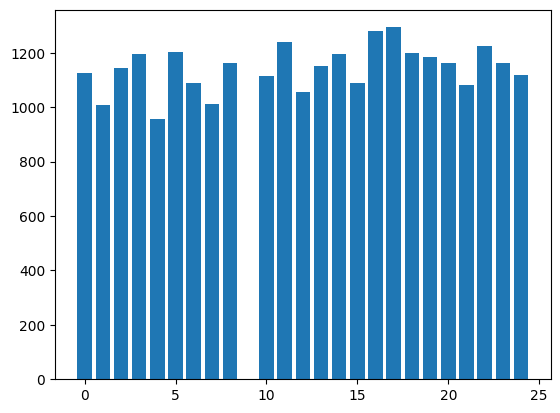

In [4]:
di = {}
for i in labels:
    if i not in di:
        di[i] = 1
    else:
        di[i] += 1


plt.bar(di.keys(), di.values())
plt.show()


In [5]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.Conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        
        )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 , 25)
        )

    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [6]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=1)
        self.labels = self.data.iloc[:, 0]
        self.pixels = self.data.iloc[:, 1:].values.astype(np.float32) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = torch.tensor(self.labels[index])
        pixels = torch.tensor(self.pixels[index]).reshape((1, 28, 28))
        return pixels, label

In [7]:
train_dataset = CSVDataset('dataset/sign_mnist_train/sign_mnist_train.csv')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [9]:
pixels, label = train_dataset[0]
print('Forme des pixels :', pixels.shape)
print('Forme de l\'étiquette :', label.shape)


Forme des pixels : torch.Size([1, 28, 28])
Forme de l'étiquette : torch.Size([])


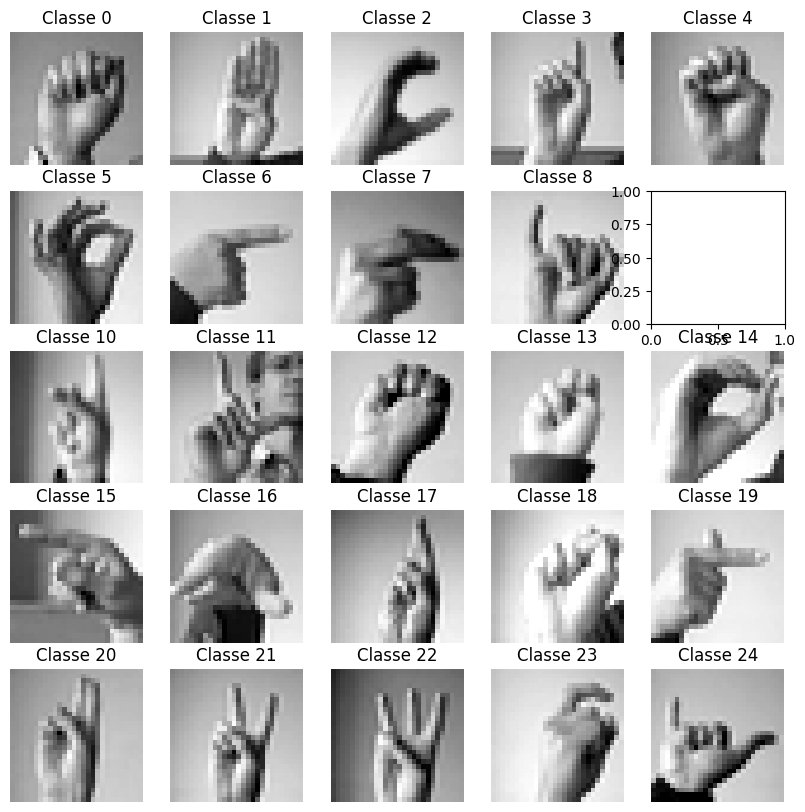

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i in range(100):
    pixels, label = train_dataset[i]
    ax = axs[label // 5, label % 5]
    ax.imshow(pixels.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Classe {label.item()}')

In [11]:
model = Classifier()

# Vérifier que PyTorch est installé avec le support CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilisation du GPU pour l'entraînement")
else:
    device = torch.device("cpu")
    print("Utilisation du CPU pour l'entraînement")

# Déplacer le modèle vers le dispositif cible
model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Définir le nombre d'époques et la taille du lot
num_epochs = 10
batch_size = 128

# Créer un DataLoader pour charger les données en lots
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Charger le dataset de test à partir du fichier CSV
test_dataset = CSVDataset('dataset/sign_mnist_test/sign_mnist_test.csv')

# Créer un DataLoader pour charger les données de test en lots
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Entraîner le modèle
precision = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        pixels, labels = data
        pixels, labels = pixels.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    """
    model.eval()
    num_correct = 0
    num_total = 0

    with torch.no_grad():
        for data in test_loader:
            pixels, labels = data
            pixels, labels = pixels.to(device), labels.to(device)
            outputs = model(pixels)
            _, predicted = torch.max(outputs.data, 1)
            num_correct += (predicted == labels).sum().item()
            num_total += labels.size(0)

        # Calculer la précision du modèle
        accuracy = num_correct / num_total
        precision.append(accuracy)
    # Switch to training mode
    model.train()
    """
    # Rest of your training code...
    print(f'Époque {epoch + 1}, perte : {running_loss / len(train_loader)}, précision : {0}')
torch.save(model.state_dict(), 'model_checkpoint.pth')


Utilisation du GPU pour l'entraînement
Époque 1, perte : 1.4937728055687838, précision : 0
Époque 2, perte : 0.383342444896698, précision : 0
Époque 3, perte : 0.16744842456523762, précision : 0
Époque 4, perte : 0.08813589679640393, précision : 0
Époque 5, perte : 0.053147142181216286, précision : 0
Époque 6, perte : 0.03601383118088855, précision : 0
Époque 7, perte : 0.024424900915906874, précision : 0
Époque 8, perte : 0.01786626053670811, précision : 0
Époque 9, perte : 0.013868290987298932, précision : 0
Époque 10, perte : 0.01112565390635715, précision : 0


In [12]:
# Charger le modèle entraîné
model = Classifier()
model.load_state_dict(torch.load('model_checkpoint.pth'))

# Charger le dataset de test à partir du fichier CSV
test_dataset = CSVDataset('dataset/sign_mnist_test/sign_mnist_test.csv')

# Créer un DataLoader pour charger les données de test en lots
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Désactiver le mode d'entraînement du modèle
model.eval()

# Initialiser les compteurs de prédictions correctes et totales
num_correct = 0
num_total = 0

# Parcourir le DataLoader de test
with torch.no_grad():
    for data in test_loader:
        pixels, labels = data
        outputs = model(pixels)
        _, predicted = torch.max(outputs.data, 1)
        num_correct += (predicted == labels).sum().item()
        num_total += labels.size(0)

# Calculer la précision du modèle
accuracy = num_correct / num_total
print(f'Précision du modèle : {accuracy:.4f}')

Précision du modèle : 0.9794


In [13]:
print(model)

Classifier(
  (Conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 